# Домашнее задание №1

## EDA

In [1]:
import torch
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
def get_loader(train, batch_size):
    
    dataset = datasets.MNIST(
        'mnist', 
        train=train, 
        download=False,
        transform=transforms.ToTensor()
    )
    
    loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True
    )
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

In [3]:
dataiter = iter(train)
X, y = dataiter.next()
print(X.shape)
print(y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [4]:
print(torch.min(X), torch.max(X))

tensor(0.) tensor(1.)


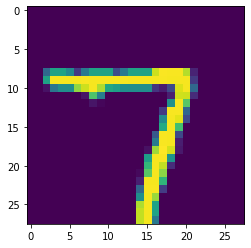

In [5]:
plt.imshow(X[0].numpy().squeeze());

## Задание 1

In [6]:
model = nn.Sequential(
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax(dim=1)
)


In [7]:
def accuracy(model, val):
    total, correct = 0, 0
    for X, y in val:
        X = X.view(X.shape[0], -1)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [8]:
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.01,
    momentum=0.8
)

criterion = nn.NLLLoss()

0.9077833333333334 0.9102
0.9379833333333333 0.9358
0.9517166666666667 0.9489
0.96295 0.9601
0.9691166666666666 0.9629
0.9751333333333333 0.9681
0.9784666666666667 0.972
0.9809 0.973
0.98395 0.975
0.9867333333333334 0.9766
0.9872166666666666 0.9752
0.99035 0.9777
0.9917666666666667 0.9789
0.9922833333333333 0.9789
0.9929333333333333 0.9782


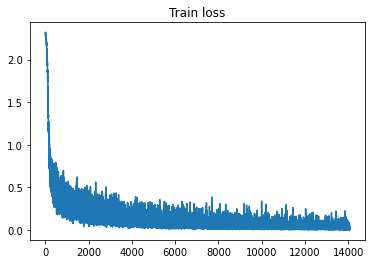

In [9]:
train_losses = []

for epoch in range(15):
    
    for X, y in train:
        
        X = X.view(X.shape[0], -1) 
        
        optimizer.zero_grad()
        
        output = model(X)
        
        loss = criterion(output, y)
        loss.backward()
        
        train_losses.append(loss.item())

        optimizer.step()
    
    print(accuracy(model, train), accuracy(model, val))
        
plt.plot(train_losses)
plt.title('Train loss')
plt.show()

## Задание 2

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dimension=10):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dimension),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(latent_dimension, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder(latent_dimension=16)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
for epoch in range(10):
    train_loss = 0
    
    for data, _ in train:
        data = data.view(data.shape[0], -1) 
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0600
epoch 1, loss 0.0368
epoch 2, loss 0.0306
epoch 3, loss 0.0279
epoch 4, loss 0.0260
epoch 5, loss 0.0249
epoch 6, loss 0.0241
epoch 7, loss 0.0235
epoch 8, loss 0.0230
epoch 9, loss 0.0226


In [12]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [13]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            
            c = a * (1 - t) + b * t
            
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)
    
    display(HTML(ani.to_jshtml()))

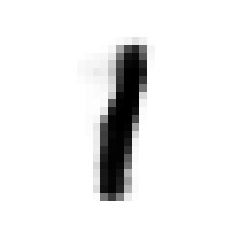

In [14]:
morph(numpy.random.randint(0, len(train.dataset), 30), 30, 30)

## Задание 3

In [15]:
model = Autoencoder(latent_dimension=2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [16]:
for epoch in range(15):
    train_loss = 0
    
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0615
epoch 1, loss 0.0485
epoch 2, loss 0.0448
epoch 3, loss 0.0430
epoch 4, loss 0.0420
epoch 5, loss 0.0413
epoch 6, loss 0.0407
epoch 7, loss 0.0402
epoch 8, loss 0.0398
epoch 9, loss 0.0395
epoch 10, loss 0.0391
epoch 11, loss 0.0389
epoch 12, loss 0.0386
epoch 13, loss 0.0384
epoch 14, loss 0.0381


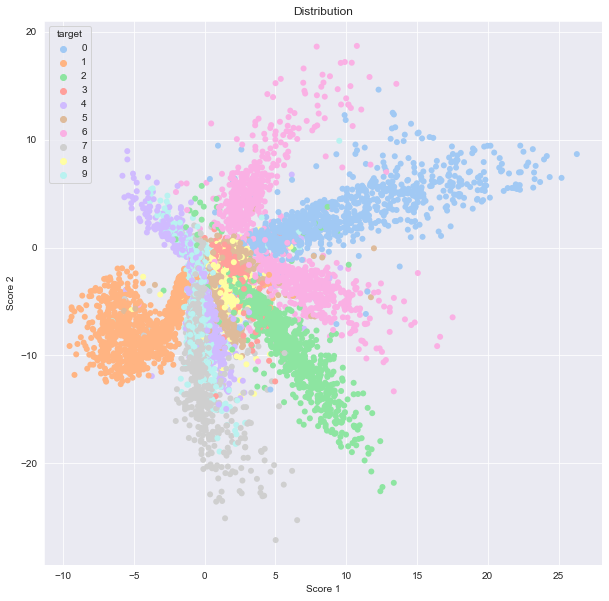

In [17]:
sns.set_style('darkgrid')

res = pd.DataFrame({
    'Score 1': [1],
    'Score 2': [1],
    'target': [1]
})

for X, y in val:
    
    X = X.view(-1, 784)

    encoded = model.encode(X).detach().numpy()
    target = y.detach().numpy()
    
    data = np.concatenate((encoded, target.reshape(-1, 1)), axis=1)
    
    df = pd.DataFrame({
        'Score 1': data[:, 0],
        'Score 2': data[:, 1],
        'target': data[:, 2].astype('int')
    })
    
    res = pd.concat((res, df))

    
plt.figure(figsize=(10, 10))

sns.scatterplot(
    data=res, 
    x='Score 1',
    y='Score 2', 
    hue='target', 
    palette='pastel',
    legend='full',
    linewidth=0
)

plt.title('Distribution')
plt.show()